# UGC Confidence Email A/B Test (Retail Case Study)

## TL;DR
Paid-acquisition users who received a post-purchase UGC confidence email had a significantly higher D30 repeat purchase rate (**14.8% vs 8.9%**, +5.9 pp, +66%), with no increase in returns and a **~11 pp reduction** in discount usage on repeat orders.

**Goal:** Improve retention for paid-acquisition users without relying on discounts.  
**Treatment:** UGC confidence email sent 5–7 days after delivery.  
**Primary Metric:** D30 repeat purchase rate.


In [23]:
%pip install statsmodels
%pip install matplotlib
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import matplotlib.pyplot as plt

plt.style.use("default")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
df = pd.read_csv(
    "../data/retail_paid_vs_organic_ugc_experiment.csv",
    parse_dates=["first_purchase_date", "delivery_date", "ugc_email_sent_date"]
)

df.head()


,user_id,acquisition_channel,variant,first_purchase_date,delivery_date,ugc_email_sent_date,ugc_email_opened,ugc_email_clicked,category,region,first_order_value,returned_within_14d,repeat_purchase_within_30d,time_to_next_purchase_days,repeat_order_value,discount_used_on_repeat
0,1,paid,control,2025-11-16,2025-11-19,NaT,0,0,footwear,NE,112.12,0,0,NaN,NaN,0
1,2,paid,treatment,2025-11-11,2025-11-17,2025-11-24,0,0,beauty,South,22.41,0,0,NaN,NaN,0
2,3,paid,treatment,2025-10-07,2025-10-10,2025-10-17,1,1,apparel,West,98.76,0,0,NaN,NaN,0
3,4,paid,control,2025-10-11,2025-10-14,NaT,0,0,electronics,NE,100.51,0,0,NaN,NaN,0
4,5,paid,control,2025-11-24,2025-11-26,NaT,0,0,footwear,NE,110.19,1,0,NaN,NaN,0


In [25]:
print("Shape:", df.shape)
print("Duplicate users:", df["user_id"].duplicated().sum())

df["acquisition_channel"].value_counts(), df["variant"].value_counts()


Shape: (20000, 16)
Duplicate users: 0


(acquisition_channel
 paid       12000
 organic     8000
 Name: count, dtype: int64,
 variant
 benchmark    8000
 control      6033
 treatment    5967
 Name: count, dtype: int64)

## Phase 2 — Data Validation & Cohort Setup

We validate dataset integrity, ensure correct cohort assignment, confirm randomization balance between paid control and treatment users, and verify that the UGC email was delivered only to treatment users within the intended post-delivery window.


In [26]:
paid = df[df.acquisition_channel == "paid"].copy()
organic = df[df.acquisition_channel == "organic"].copy()

paid_ctrl = paid[paid.variant == "control"].copy()
paid_trt  = paid[paid.variant == "treatment"].copy()

paid_ctrl.shape, paid_trt.shape, organic.shape


((6033, 16), (5967, 16), (8000, 16))

In [27]:
balance = pd.DataFrame({
    "metric": ["first_order_value", "returned_within_14d"],
    "control_mean": [
        paid_ctrl["first_order_value"].mean(),
        paid_ctrl["returned_within_14d"].mean()
    ],
    "treatment_mean": [
        paid_trt["first_order_value"].mean(),
        paid_trt["returned_within_14d"].mean()
    ]
})

balance["diff"] = balance["treatment_mean"] - balance["control_mean"]
balance


,metric,control_mean,treatment_mean,diff
0,first_order_value,73.725249,74.544022,0.818773
1,returned_within_14d,0.141555,0.143958,0.002404


In [28]:
paid_trt["days_after_delivery"] = (
    paid_trt["ugc_email_sent_date"] - paid_trt["delivery_date"]
).dt.days

paid_trt["days_after_delivery"].describe()


count    5967.000000
mean        6.026311
std         0.817270
min         5.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         7.000000
Name: days_after_delivery, dtype: float64

## Phase 3 — Primary Impact Analysis (Causal)

We estimate the causal impact of the UGC confidence email on **D30 repeat purchase** using a two-proportion z-test within the randomized paid cohort.


In [29]:
ctrl_n = paid_ctrl.shape[0]
trt_n  = paid_trt.shape[0]

ctrl_success = paid_ctrl["repeat_purchase_within_30d"].sum()
trt_success  = paid_trt["repeat_purchase_within_30d"].sum()

ctrl_rate = ctrl_success / ctrl_n
trt_rate  = trt_success / trt_n

abs_lift_pp = (trt_rate - ctrl_rate) * 100
rel_lift_pct = abs_lift_pp / (ctrl_rate * 100) * 100

count = np.array([trt_success, ctrl_success])
nobs  = np.array([trt_n, ctrl_n])

z, p = proportions_ztest(count, nobs)
ci_low, ci_high = confint_proportions_2indep(
    trt_success, trt_n,
    ctrl_success, ctrl_n
)

print(f"Control repeat rate: {ctrl_rate:.4f}")
print(f"Treatment repeat rate: {trt_rate:.4f}")
print(f"Absolute lift (pp): {abs_lift_pp:.2f}")
print(f"Relative lift (%): {rel_lift_pct:.2f}")
print(f"P-value: {p:.6f}")
print(f"95% CI (pp): ({ci_low*100:.2f}, {ci_high*100:.2f})")


Control repeat rate: 0.0892
Treatment repeat rate: 0.1483
Absolute lift (pp): 5.91
Relative lift (%): 66.32
P-value: 0.000000
95% CI (pp): (4.76, 7.07)


## Phase 4 — Guardrails & Secondary Metrics

We verify that the treatment does not negatively impact returns, order quality, or user behavior.


In [30]:
ret_ctrl = paid_ctrl["returned_within_14d"].sum()
ret_trt  = paid_trt["returned_within_14d"].sum()

count = np.array([ret_trt, ret_ctrl])
nobs  = np.array([paid_trt.shape[0], paid_ctrl.shape[0]])

z, p = proportions_ztest(count, nobs)

print("Return rate control:", paid_ctrl["returned_within_14d"].mean())
print("Return rate treatment:", paid_trt["returned_within_14d"].mean())
print("p-value:", p)


Return rate control: 0.14155478203215646
Return rate treatment: 0.14395843807608513
p-value: 0.7066614440103604


In [31]:
ctrl_rep = paid_ctrl[paid_ctrl.repeat_purchase_within_30d == 1]
trt_rep  = paid_trt[paid_trt.repeat_purchase_within_30d == 1]

ctrl_rep["time_to_next_purchase_days"].median(), trt_rep["time_to_next_purchase_days"].median()


(10.0, 11.0)

In [32]:
disc_ctrl = ctrl_rep["discount_used_on_repeat"].mean() * 100
disc_trt  = trt_rep["discount_used_on_repeat"].mean() * 100

disc_ctrl, disc_trt


(49.814126394052046, 39.09604519774012)

## Phase 5 — Diagnostics & Segmentation

We analyze engagement effects (openers vs non-openers) and heterogeneity by category and region to understand **why** the experiment worked.


In [33]:
trt_open = paid_trt[paid_trt.ugc_email_opened == 1]
trt_noopen = paid_trt[paid_trt.ugc_email_opened == 0]

summary = pd.DataFrame({
    "group": ["control", "treatment_opened", "treatment_not_opened"],
    "repeat_rate": [
        paid_ctrl.repeat_purchase_within_30d.mean(),
        trt_open.repeat_purchase_within_30d.mean(),
        trt_noopen.repeat_purchase_within_30d.mean()
    ]
})

summary["repeat_rate_pct"] = (summary["repeat_rate"] * 100).round(2)
summary[["group", "repeat_rate_pct"]]


,group,repeat_rate_pct
0,control,8.92
1,treatment_opened,18.11
2,treatment_not_opened,13.02


In [34]:
cat = (
    paid.groupby(["category", "variant"])["repeat_purchase_within_30d"]
    .mean()
    .unstack()
)

cat["lift_pp"] = (cat["treatment"] - cat["control"]) * 100
cat.sort_values("lift_pp", ascending=False)


variant,control,treatment,lift_pp
category,,,
home,0.082179,0.155070,7.289045
apparel,0.095447,0.165000,6.955293
footwear,0.085865,0.144168,5.830250
electronics,0.061303,0.108828,4.752532
beauty,0.122066,0.165129,4.306342


In [35]:
reg = (
    paid.groupby(["region", "variant"])["repeat_purchase_within_30d"]
    .mean()
    .unstack()
)

reg["lift_pp"] = (reg["treatment"] - reg["control"]) * 100
reg.sort_values("lift_pp", ascending=False)


variant,control,treatment,lift_pp
region,,,
NE,0.087899,0.160360,7.246150
West,0.082689,0.144061,6.137197
South,0.089894,0.141860,5.196622
Midwest,0.095930,0.145654,4.972364


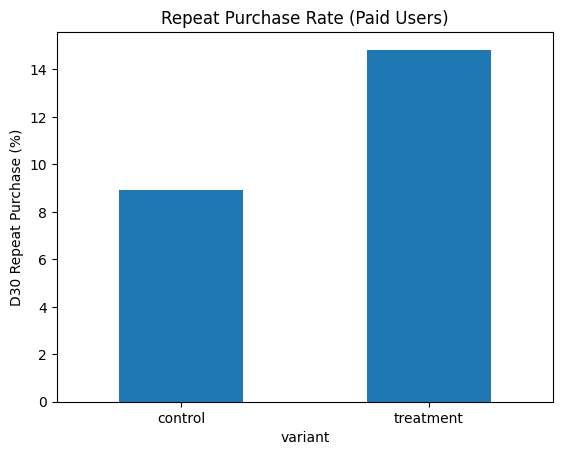

In [36]:
rates = paid.groupby("variant")["repeat_purchase_within_30d"].mean().loc[["control","treatment"]] * 100

rates.plot(kind="bar", title="Repeat Purchase Rate (Paid Users)")
plt.ylabel("D30 Repeat Purchase (%)")
plt.xticks(rotation=0)
plt.show()


## Executive Summary

- **Primary impact:** D30 repeat purchase increased from **8.9% → 14.8%** (+5.9 pp, +66%)
- **Guardrails:** No increase in returns or degradation in order value
- **Margin impact:** Discount usage on repeat dropped by ~11 pp
- **Mechanism:** Lift driven primarily by users who opened the UGC email
- **Best categories:** Home, Apparel, Footwear
- **Decision:** Ship and scale with monitoring and creative optimization
